In [1]:
import sqlite3
import numpy as np
import matplotlib as mp
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from matplotlib.backends.backend_pdf import PdfPages
import itertools as it

from matplotlib import rcParams
rcParams.update({'figure.autolayout': True})

table = {}

#print(mp.__version__)

%matplotlib inline

In [2]:
def select_by(db, name, type):

    S = """select s1.ts,s1.type,s1.tid,s1.iter,(s2.ts-s1.ts),s1.heap,s2.heap,s1.details
  from stats s1 inner join stats s2 on s1.tid=s2.tid and s1.iter=s2.iter and s1.action!=s2.action and s1.type=s2.type
 where s1.type='{type}' and s1.action='start' and s1.name = '{name}' and s2.name = '{name}'
 order by s1.ts asc;"""
    cur = db.cursor()
    r = []
    #print S.format(type=type, name=name)
    for row in cur.execute(S.format(type=type, name=name)):
        r.append(row)
    return r

def csv(a, N=-1):
    n = 0
    for i in a:
        print ",".join(str(x) for x in i)
        if N > 0:
            if n < N:
                n += 1
            else:
                break


In [7]:
def load_data_set(name):
    db = sqlite3.connect("stats.sql")
    DS = ''
    a = select_by(db, name, 'compute')
    b = select_by(db, name, 'gc')
    #c = a + b
    #c.sort(key=lambda a: a[0])
    #csv(c)
    db.close()
    return a,b


In [8]:
def gen_graph(name='20170430-hask-p9', W=100, B=30, 
              FS=18, DISCARD=0,
              HEAP=True, CTLOG=True, HEAPLOG=True,
              CTLO=(0,0), HEAPLO=(0,0), NOREGIONS=False,
              CTLABEL=True, HEAPLABEL=True,
              XDIV=10^3, YDIV=10^3,
              HEAPALPHA=0.75, HEAPDIV=(1024*1024), HEAPUNITS="Mbytes"):
    """
    DISCARD = discard this many data points from the start of the
         dataset. initial datapoints likely to be contain skew as
         OS process initializes (e.g. JIT) and stablizes
    W = width of graph (number of data points to include)
    B = cut off when GC thread kicks in (usually around the 30th data point
        but you should inspect the "raw" file and count the number of "comp:start"
        entries until you see the first "gc:start" and use that count as B.)
    FS = font size for axis labels/title
    HEAP = T|F show heap line on chart
    CTLOG = T|F apply log scale to compute thread line
    HEAPLOG = T|F apply log scale to heap line
    CTLO = (δx,δy) tuple allowing for adjustment of compute stats (mu/sigma label)
    HEAPLO = (δx, δy) tuple allow for adjustment of heap stats (mu/sigma label)
    """
    a, b = load_data_set(name)

    xs = [(x[0]-a[0][0])/(XDIV) for x in a]
    ys = [x[4]/(YDIV) for x in a]
    heapys = [(x[5]/HEAPDIV) for x in a]

    #for i, v in enumerate(ys[:W]):
    #    print i, v

    W_ = W - B + DISCARD
    mean0, mean1 = np.mean(ys[DISCARD:B]), np.mean(ys[DISCARD+B:W])
    std0, std1 = np.std(ys[DISCARD:B]), np.std(ys[DISCARD+B:W])
    #print mean0, std0
    #print mean1, std1
    #print xs[:10]

    L0 = "RT/-MP\n$\mu$={0:.2f},\n$\sigma={1:.2f}$".format(mean0, std0)
    L1 = "RT/+MP\n$\mu$={0:.2f},\n$\sigma={1:.2f}$".format(mean1, std1)

    fig, ax1 = plt.subplots(dpi=120, figsize=(7,7))
    ax2 = ax1.twinx()
    ax1.plot(xs[DISCARD:W], ys[DISCARD:W], 'bo', markerfacecolor='none')
    #plt.tight_layout()

    if CTLOG is True:
        ax1.set_yscale('log')
    if HEAP is True:
        ax2.plot(xs[DISCARD:W], heapys[DISCARD:W], 'r-', alpha=HEAPALPHA)
    if HEAPLOG is True:
        ax2.set_yscale('log')

    ax1.set_xlabel(r"Delta Iteration Start Time ($sec$)", fontsize=FS)
    ax1.set_ylabel("Run Time ($ms$)", color='blue', fontsize=FS)
    ax2.set_ylabel("Heap Used (${}$)".format(HEAPUNITS), color='red', fontsize=FS)
    #plt.plot(xs[:W], ys[:W], 'bs')
    try:
        # *XDIV doesnt do what I expected so I left it out for now
        if CTLABEL:
            ax1.text(0.0 + CTLO[0]*XDIV, mean0*2 + CTLO[1], L0)
        if HEAPLABEL:
            ax1.text(xs[50] + HEAPLO[0]*XDIV, mean1 + HEAPLO[1], L1)
    except Exception as e:
        print "Failed to place mu/sigma text: ", e

    ax1.set_title(a[0][7], fontsize=FS)

    xs_ = np.array(xs)
    ys_ = np.array(ys)
    heapys_ = np.array(heapys)
    #print name
    #print "xs_ ", np.shape(xs_), np.min(xs_), np.max(xs_)
    #print "ys_ ", np.shape(ys_), np.min(ys_), np.max(ys_)
    #print "hp  ", np.shape(heapys_), np.min(heapys_), np.max(heapys_)
    #print "xs_30 ", xs_[B-1]
    
    if NOREGIONS is False:
        sub = fig.gca()
        sub.add_patch(
            patches.Rectangle(
                (np.min(xs_), np.min(heapys_)), #(-1e6, 0),      # (x,y)
                xs_[B],                         # 1e6 + 3*10**6, # width
                np.max(heapys_),                # 700            # height
                alpha=0.1, facecolor="#555555"
            )
        )
        sub.add_patch(
            patches.Rectangle(
                (xs_[B], np.min(heapys_)), # (3*10**6, 00), # (x,y)
                np.max(xs_), # 1.2*10**7,     # width
                np.max(heapys_), #6000,          # height
                alpha=0.1, facecolor="#AAAAAA"
            )
        )
    
    pp = PdfPages("{}.pdf".format(name))
    pp.savefig(fig)
    pp.close()
    
    return {name: [mean0, mean1, std0, std1]}

In [9]:
def analyze_outliers(name='noidear', W=100, B=30, 
              FS=18, DISCARD=0,
              HEAP=True, CTLOG=True, HEAPLOG=True,
              CTLO=(0,0), HEAPLO=(0,0), NOREGIONS=False,
              CTLABEL=True, HEAPLABEL=True,
              XDIV=10^3, YDIV=10^3,
              HEAPALPHA=0.75, HEAPDIV=(1024*1024), HEAPUNITS="Mbytes"):
    """
    DISCARD = discard this many data points from the start of the
         dataset. initial datapoints likely to be contain skew as
         OS process initializes (e.g. JIT) and stablizes
    W = width of graph (number of data points to include)
    B = cut off when GC thread kicks in (usually around the 30th data point
        but you should inspect the "raw" file and count the number of "comp:start"
        entries until you see the first "gc:start" and use that count as B.)
    FS = font size for axis labels/title
    HEAP = T|F show heap line on chart
    CTLOG = T|F apply log scale to compute thread line
    HEAPLOG = T|F apply log scale to heap line
    CTLO = (δx,δy) tuple allowing for adjustment of compute stats (mu/sigma label)
    HEAPLO = (δx, δy) tuple allow for adjustment of heap stats (mu/sigma label)
    """
    a, b = load_data_set(name)

    xs = [(x[0]-a[0][0])/(XDIV) for x in a]
    ys = [x[4]/(YDIV) for x in a]
    heapys = [(x[5]/HEAPDIV) for x in a]

    #for i, v in enumerate(ys[:W]):
    #    print i, v

    W_ = W - B + DISCARD
    mean0, mean1 = np.mean(ys[DISCARD:B]), np.mean(ys[DISCARD+B:W])
    std0, std1 = np.std(ys[DISCARD:B]), np.std(ys[DISCARD+B:W])
    #print mean0, std0
    #print mean1, std1
    #print xs[:10]
    
    # how many datapoints in ys[DISCARD+B:W_] exceed mean0+std0?
    
    c = 0
    for i in ys[DISCARD+B:W]:
        #print i, mean0+std0
        if i > mean0+std0:
            c += 1
    n = name.split('-')
    print "{0} & {1} & {2:.2f} \\\\ %% {3} {4}".format(n[1], n[2], float(c)/(W-B-DISCARD), c, (W-B-DISCARD))

In [6]:
analyze_outliers(name='20170925-cloj-gcb-loop', W=100, B=40, DISCARD=3, XDIV=1000, YDIV=1)
analyze_outliers(name='20170919-cloj-p9-loop', W=100, B=40, DISCARD=3, XDIV=1000, YDIV=1)
analyze_outliers(name='20170927-hask-gcb', W=100, B=45, DISCARD=3, XDIV=1, YDIV=0.001)
analyze_outliers(name='20170927-hask-p9', W=100, B=45, DISCARD=3, XDIV=1, YDIV=0.001)
analyze_outliers(name='20170919-scala-gcb-loop', W=200, B=35, DISCARD=3, XDIV=1000, YDIV=1)
analyze_outliers(name='20170919-scala-p9-loop', W=200, B=38, DISCARD=3, XDIV=1000, YDIV=1)
analyze_outliers(name='20170830-mlton-gcb', W=200, B=60, DISCARD=3, XDIV=1000, YDIV=1)
analyze_outliers(name='20170831-mlton-p9', W=200, B=60, DISCARD=3, XDIV=1000, YDIV=1, HEAPDIV=1)


cloj & gcb & 0.40 \\ %% 23 57
cloj & p9 & 0.84 \\ %% 48 57
hask & gcb & 1.00 \\ %% 52 52
hask & p9 & 1.00 \\ %% 52 52
scala & gcb & 1.00 \\ %% 162 162
scala & p9 & 0.97 \\ %% 154 159
mlton & gcb & 1.00 \\ %% 137 137
mlton & p9 & 1.00 \\ %% 137 137


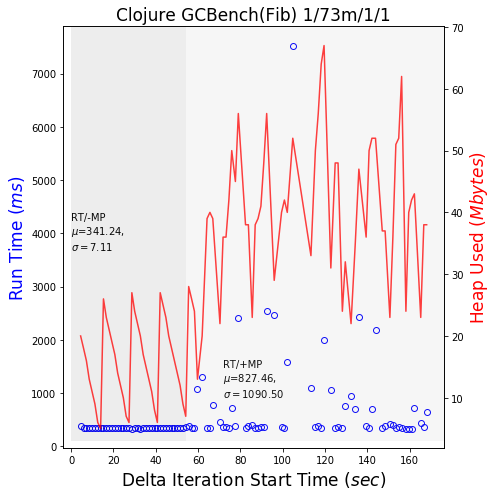

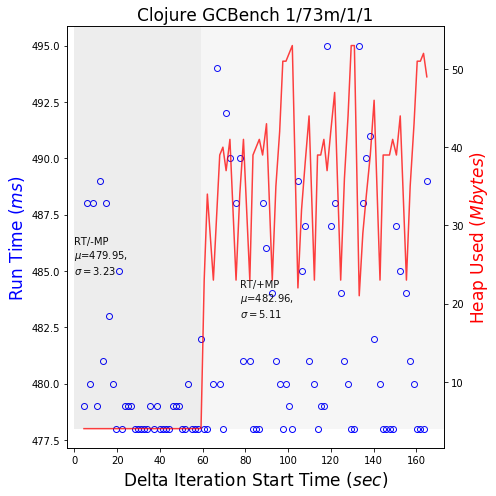

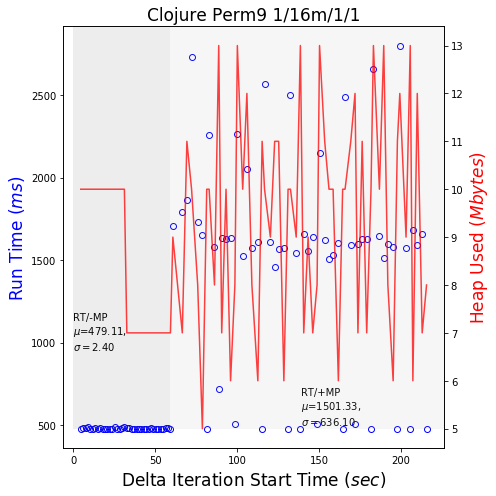

In [11]:
r = gen_graph(name='20170926-cloj-gcb-fib', W=100, B=40, FS=17, HEAP=True, 
          CTLOG=False, HEAPLOG=False, DISCARD=3,
          XDIV=1000, YDIV=1, CTLABEL=True, CTLO=(0,3000), HEAPLABEL=True, HEAPLO=(0,100))
table.update(r)


r = gen_graph(name='20170925-cloj-gcb-loop', W=100, B=40, FS=17, HEAP=True, 
          CTLOG=False, HEAPLOG=False, DISCARD=3,
          XDIV=1000, YDIV=1, CTLABEL=True, CTLO=(0,-475), HEAPLABEL=True, HEAPLO=(0,0))
table.update(r)


r = gen_graph(name='20170919-cloj-p9-loop', W=100, B=40, FS=17, HEAP=True, 
          CTLOG=False, HEAPLOG=False, DISCARD=3,
          XDIV=1000, YDIV=1, CTLABEL=True, CTLO=(0,0), HEAPLABEL=True, HEAPLO=(0.05,-1000))
table.update(r)



/Users/jcmurphy/.virtualenvs/tapio/lib/python2.7/site-packages/matplotlib/figure.py:1743: UserWarning: This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.
  warnings.warn("This figure includes Axes that are not "


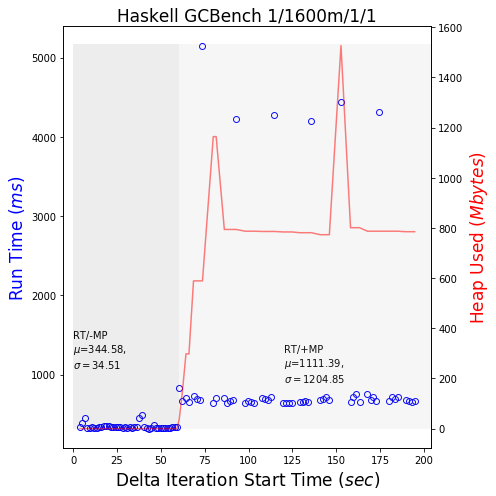

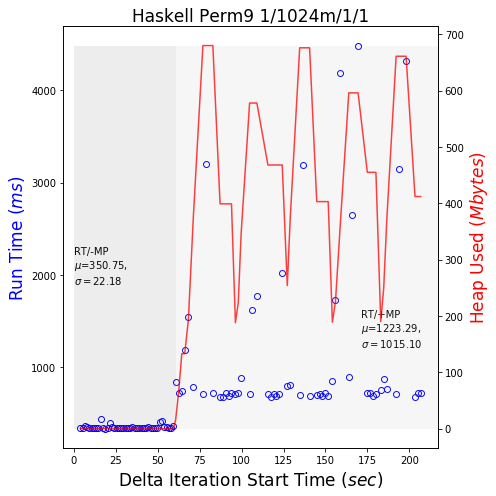

In [10]:
r = gen_graph(name='20170927-hask-gcb', W=100, B=45, FS=17, HEAP=True, 
          CTLOG=False, HEAPLOG=False, DISCARD=3,
          XDIV=1, YDIV=0.001, CTLABEL=True, CTLO=(0,400), HEAPLABEL=True, HEAPLO=(50,-200), HEAPALPHA=0.5)
table.update(r)

r = gen_graph(name='20170927-hask-p9', W=100, B=45, FS=17, HEAP=True, 
          CTLOG=False, HEAPLOG=False, DISCARD=3,
          XDIV=1, YDIV=0.001, CTLABEL=True, CTLO=(0,1200), HEAPLABEL=True, HEAPLO=(100,0))
table.update(r)


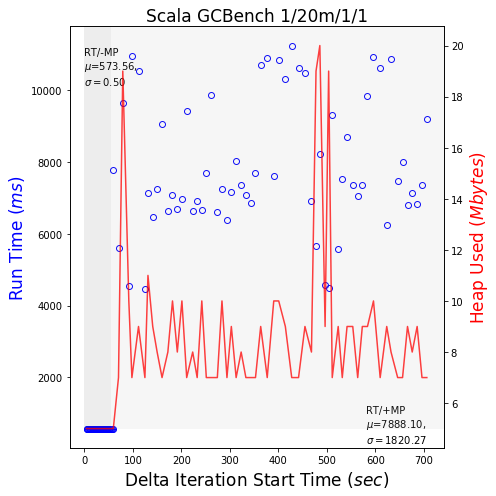

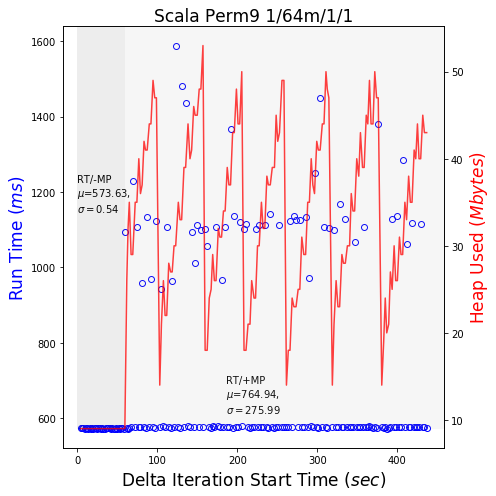

In [11]:
r = gen_graph(name='20170919-scala-gcb-loop', W=100, B=35, FS=17, HEAP=True, 
          CTLOG=False, HEAPLOG=False, DISCARD=3,
          XDIV=1000, YDIV=1, CTLABEL=True, CTLO=(0,9000), HEAPLABEL=True, HEAPLO=(.4,-7700))
table.update(r)


r = gen_graph(name='20170919-scala-p9-loop', W=200, B=38, FS=17, HEAP=True, 
          CTLOG=False, HEAPLOG=False, DISCARD=3,
          XDIV=1000, YDIV=1, CTLABEL=True, CTLO=(0,0), HEAPLABEL=True, HEAPLO=(.1,-150))
table.update(r)


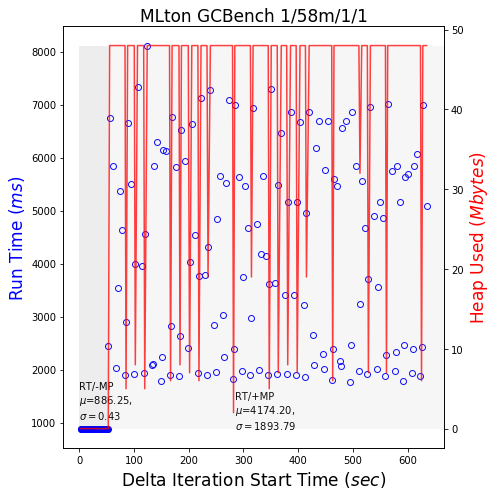

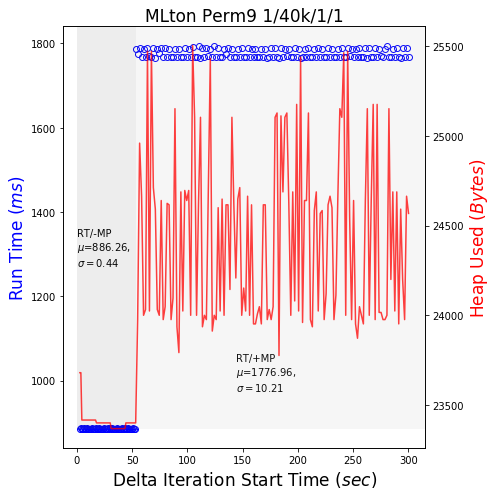

In [12]:
r = gen_graph(name='20170830-mlton-gcb', W=200, B=60, FS=17, HEAP=True, 
          CTLOG=False, HEAPLOG=False, DISCARD=3,
          XDIV=1000, YDIV=1, CTLABEL=True, CTLO=(0,-700), HEAPLABEL=True, HEAPLO=(.24,-3300))
table.update(r)

r = gen_graph(name='20170831-mlton-p9', W=200, B=60, FS=17, HEAP=True, 
          CTLOG=False, HEAPLOG=False, DISCARD=3,
          XDIV=1000, YDIV=1, CTLABEL=True, CTLO=(0,-500), HEAPLABEL=True, HEAPLO=(.1,-800), 
          HEAPDIV=1, HEAPUNITS="Bytes")
table.update(r)


In [13]:
for name in table:
    m0, m1, s0, s1 = table[name]
    n = name.split('-')
    print "{0} \t& {1} \t& {2:.2f} \t& {3:.2f} \t& {4:.2f} \t& {5:.2f}   \\\\ %%  {6}".format(n[1], n[2], m0, s0, m1, s1, name)

scala 	& gcb 	& 573.56 	& 0.50 	& 7888.10 	& 1820.27   \\ %%  20170919-scala-gcb-loop
mlton 	& gcb 	& 886.25 	& 0.43 	& 4174.20 	& 1893.79   \\ %%  20170830-mlton-gcb
cloj 	& gcb 	& 341.24 	& 7.11 	& 827.46 	& 1090.50   \\ %%  20170926-cloj-gcb-fib
hask 	& gcb 	& 344.58 	& 34.51 	& 1111.39 	& 1204.85   \\ %%  20170927-hask-gcb
cloj 	& gcb 	& 479.95 	& 3.23 	& 482.96 	& 5.11   \\ %%  20170925-cloj-gcb-loop
hask 	& p9 	& 350.75 	& 22.18 	& 1223.29 	& 1015.10   \\ %%  20170927-hask-p9
mlton 	& p9 	& 886.26 	& 0.44 	& 1776.96 	& 10.21   \\ %%  20170831-mlton-p9
scala 	& p9 	& 573.63 	& 0.54 	& 764.94 	& 275.99   \\ %%  20170919-scala-p9-loop
cloj 	& p9 	& 479.11 	& 2.40 	& 1501.33 	& 636.10   \\ %%  20170919-cloj-p9-loop
